## Estimate edge prior

A more correct background level of edge connectivity or node pair features would be based on permutations of the unpruned network. In edge prediction, though, we do not have access to the unpruned network. This notebook investigates whether the "edge prior" based on A is the same as based on B. That is, whether we can use the edge prior from the pruned network as an estimate of the edge prior on permutations of the unpruned network.

Overall, while the correlation is apparent, the edge prior based on B is clearly not equivalent to that based on A, even when normalized relative to the difference in number of edges (information that would not be available in edge prediction either).

In [21]:
import collections
import random
import tempfile

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import tqdm
import xswap

%matplotlib inline

In [2]:
response = requests.get(
    'https://github.com/greenelab/xswap/raw/8c31b4cbdbbf2cfa5018b1277bbd0e9f6263e573'
    '/graphs/GiG_edges_reduced.txt'
)

with tempfile.NamedTemporaryFile() as f:
    f.write(response.content)
    edges = xswap.preprocessing.load_processed_edges(f.name)

# Direction swap edges so that source <= target
edges = list(set(map(tuple, map(sorted, edges))))

# Remove some edges to form "pruned" metaedge
sample_size = int(0.2 * len(edges))
random.seed(0)
sampled_edges = random.sample(edges, sample_size)
pruned_edges = list(set(edges) - set(sampled_edges))

In [3]:
a_edge_counter = None
b_edge_counter = None

a_permuted_edges = edges.copy()
b_permuted_edges = pruned_edges.copy()

for _ in tqdm.tqdm(range(1000)):
    a_permuted_edges, stats = xswap.permute_edge_list(
        a_permuted_edges, allow_self_loops=True, allow_antiparallel=False)
    
    a_perm_counter = collections.Counter(a_permuted_edges)
    if a_edge_counter is None:
        a_edge_counter = a_perm_counter
    else:
        a_edge_counter += a_perm_counter
    
    b_permuted_edges, stats = xswap.permute_edge_list(
        b_permuted_edges, allow_self_loops=True, allow_antiparallel=False)
    
    b_perm_counter = collections.Counter(b_permuted_edges)
    if b_edge_counter is None:
        b_edge_counter = b_perm_counter
    else:
        b_edge_counter += b_perm_counter

100%|██████████| 1000/1000 [08:23<00:00,  1.99it/s]


In [43]:
a_freq_df = (pd.DataFrame
             .from_dict(a_edge_counter, orient='index')
             .rename(columns={0: 'freq'})
             .reset_index()
            )
b_freq_df = (pd.DataFrame
             .from_dict(b_edge_counter, orient='index')
             .rename(columns={0: 'freq'})
             .reset_index()
            )

freq_df = a_freq_df.merge(b_freq_df, on=['index'], suffixes=('_a', '_b'))

freq_df['adj_freq_a'] = freq_df['freq_a'] / len(edges)
freq_df['adj_freq_b'] = freq_df['freq_b'] / len(pruned_edges)

max_value = freq_df[['adj_freq_a', 'adj_freq_b']].max().max()
freq_df['adj_freq_a'] = freq_df['adj_freq_a'] / max_value
freq_df['adj_freq_b'] = freq_df['adj_freq_b'] / max_value

In [44]:
freq_df.head()

,index,freq_a,freq_b,adj_freq_a,adj_freq_b
0,"(408, 2935)",34,27,0.027227,0.027027
1,"(898, 1591)",8,10,0.006406,0.010010
2,"(204, 4580)",14,12,0.011211,0.012012
3,"(497, 2841)",11,9,0.008809,0.009009
4,"(949, 4154)",3,1,0.002402,0.001001


(0, 1000)

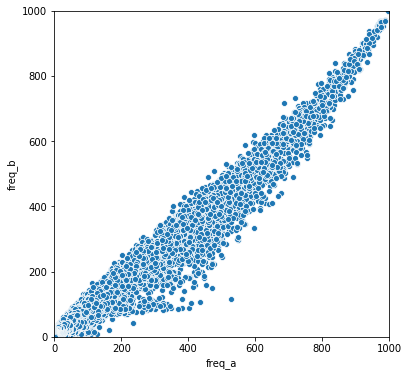

In [45]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=freq_df, x='freq_a', y='freq_b')
plt.plot([0, 0], [1000, 1000], linestyle='--')
plt.xlim(0, 1000)
plt.ylim(0, 1000)

(0, 1)

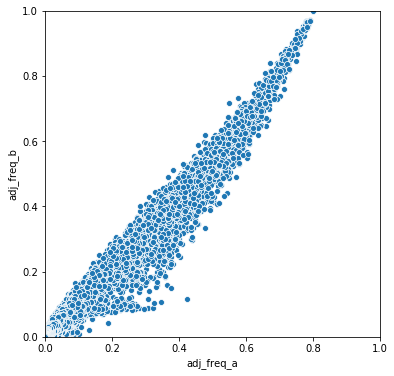

In [48]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=freq_df, x='adj_freq_a', y='adj_freq_b')
plt.xlim(0, 1)
plt.ylim(0, 1)